# Lego Database Creation

This notebook intends to create a database from the data loaded by Rachael Tatman on Kaggle

Data Collected by Rachel Tatman  
Data Source from Rebrickable  
Uploaded on Kaggle  
Link: https://www.kaggle.com/datasets/rtatman/lego-database

#### This is the schema provided on Kaggle

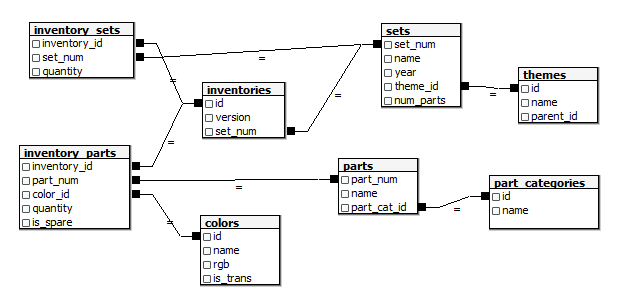

In [1]:
# Import duckdb and pandas
import duckdb
import pandas as pd

# Input the following magic commands
%load_ext sql
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

# Load the following database on memory first
%sql duckdb:///:memory

In [2]:
# Import os library to get the csv files for the database
import os

# Collect the file names that end in .csv
docs = [file for file in os.listdir() if file.endswith(".csv")]

# Inspect the list of csv files
print(docs)

['part_categories.csv', 'inventories.csv', 'parts.csv', 'inventory_sets.csv', 'inventory_parts.csv', 'colors.csv', 'sets.csv', 'themes.csv']


In [3]:
# Convert the csv files to parquet
for doc in docs:
    word = doc[:-4]
    df = pd.read_csv(doc)
    df.to_parquet("{}.parquet".format(word))

In [4]:
# Create a database called 'lego.db'
con = duckdb.connect(database='lego.db', read_only=False)

In [5]:
# Create the table for part_categories with the id as the primary key
query = '''
CREATE TABLE part_categories (
id BIGINT PRIMARY KEY,
name VARCHAR
);
'''
con.execute(query)

In [6]:
# Insert the data from the part_categories parquet file to the part_categories table
query = '''
INSERT INTO part_categories SELECT * FROM read_parquet('part_categories.parquet')
'''
con.execute(query)

In [7]:
# Create the parts table with with part_num as the primary key and column part_cat_id referencing part_categories's id column
query = '''
CREATE TABLE parts (
part_num VARCHAR PRIMARY KEY,
name VARCHAR,
part_cat_id BIGINT,
FOREIGN KEY (part_cat_id) REFERENCES part_categories(id)
);
'''
con.execute(query)

In [8]:
# Insert the data from the parts parquet file to the parts table
query = '''
INSERT INTO parts SELECT * FROM read_parquet('parts.parquet')
'''
con.execute(query)

In [9]:
# Create the colors table with id as the primary key
query = '''
CREATE TABLE colors (
id BIGINT PRIMARY KEY,
name VARCHAR,
rgb VARCHAR,
is_trans VARCHAR
);
'''
con.execute(query)

In [10]:
# Insert the data from the colors parquet file to the colors table
query = '''
INSERT INTO colors SELECT * FROM read_parquet('colors.parquet')
'''
con.execute(query)

In [11]:
# Create the themes table with id as the primary key
query = '''
CREATE TABLE themes (
id BIGINT PRIMARY KEY,
name VARCHAR,
parent_id DOUBLE
);
'''
con.execute(query)

In [12]:
# Insert the data from the themes parquet file into the themes table
query = '''
INSERT INTO themes SELECT * FROM read_parquet('themes.parquet')
'''
con.execute(query)

In [13]:
# Create the sets table with set_num as the primary key and theme_id referencing themes's id column
query = '''
CREATE TABLE sets (
set_num VARCHAR PRIMARY KEY,
name VARCHAR,
year BIGINT,
theme_id BIGINT,
num_parts BIGINT,
FOREIGN KEY (theme_id) REFERENCES themes(id)
);
'''
con.execute(query)

In [14]:
# Insert the data from the sets parquet file to the sets table
query = '''
INSERT INTO sets SELECT * FROM read_parquet('sets.parquet')
'''
con.execute(query)

In [15]:
# Create inventories table with id as the primary key and set_num referencing sets's set_num column
query = '''
CREATE TABLE inventories (
id BIGINT PRIMARY KEY,
version BIGINT,
set_num VARCHAR,
FOREIGN KEY (set_num) REFERENCES sets(set_num)
);
'''
con.execute(query)

In [16]:
# Insert the data from inventories parquet file into the inventories table
query = '''
INSERT INTO inventories SELECT * FROM read_parquet('inventories.parquet')
'''
con.execute(query)

In [17]:
# Create inventory_sets table with inventory_id referencing inventories's id column and set_num referencing sets's set_num table
query = '''
CREATE TABLE inventory_sets (
inventory_id BIGINT,
set_num VARCHAR,
quantity BIGINT,
FOREIGN KEY (inventory_id) REFERENCES inventories(id), 
FOREIGN KEY (set_num) REFERENCES sets(set_num)
);
'''
con.execute(query)

In [18]:
# Insert the data from inventory_sets parquet file into the inventory_sets table
query = '''
INSERT INTO inventory_sets SELECT * FROM read_parquet('inventory_sets.parquet')
'''
con.execute(query)

In [19]:
# Create inventory_parts table with inventory_id referencing inventories's id column and color_id referencing colors's id column
query = '''
CREATE TABLE inventory_parts (
inventory_id BIGINT,
part_num VARCHAR,
color_id BIGINT,
quantity BIGINT,
is_spare VARCHAR,
FOREIGN KEY (inventory_id) REFERENCES inventories(id),
FOREIGN KEY (color_id) REFERENCES colors(id)
);
'''
con.execute(query)

In [20]:
# Insert the data from inventory_parts parquet file into the inventory_parts table
query = '''
INSERT INTO inventory_parts SELECT * FROM read_parquet('inventory_parts.parquet')
'''
con.execute(query)

In [21]:
# Close the connection
con.close()